# Estimation problems

In this tutorial, we explain one of the greatest features of GeoStats.jl: the ability to setup geostatistical problems indenpendently of the solution strategy.

If you are an experienced user of geostatistics or if you do research in the field, you know how hard it is to compare algorithms fairly. Often a new algorithm is proposed in the literature, and yet the task of comparing it with the state of the art is quite demanding. Even when a comparison is made by the author after a great amount of effort, it is inevitably biased.

Part of this issue is attributed to the fact that a general definition of the problem is missing. What is it that we call an "estimation problem" in geostatistics? The answer to this question is given below in the form of code.

Before we proceed, please instantiate the environment:

In [1]:
using Pkg
push!(empty!(LOAD_PATH), @__DIR__)
Pkg.instantiate()

In [2]:
using Random; Random.seed!(2000); # make sure this tutorial is reproducible

## Problem definition

An estimation problem in geostatistics is a triplet:

1. Spatial data (i.e. data with coordinates)
2. Spatial domain (e.g. regular grid, unstructured grid)
3. Target variables (or variables to be estimated)

It doesn't involve variograms, training images, or any tuning parameter. These concepts belong to solvers.

Let's make it a concrete example, and create some data:

In [3]:
using GeoStats

sdata = readgeotable("data/precipitation.csv", coordnames=[:x,:y])

,x,y,station,precipitation
,Float64,Float64,String,Float64
1,25.0,25.0,palo alto,1.0
2,50.0,75.0,redwood city,0.0
3,75.0,50.0,mountain view,1.0


The `GeoDataFrame` type is defined in GeoStats.jl as a lightweight wrapper over Julia's DataFrame types. Besides the data, it stores the name of the columns representing spatial coordinates. In this example, we used the `readgeotable` utility function to read the data directly from disk.

Next, we define the domain in which the variables will be estimated. One of the many choices possible is the regular grid:

In [4]:
sdomain = RegularGrid{Float64}(100, 100)

100×100 RegularGrid{Float64,2}
  origin:     (0.0, 0.0)
  spacing:    (1.0, 1.0)

Notice that by default, a regular grid has zero origin and unit spacing. Alternatively, these parameters can be specified explicitly:

In [5]:
sdomain = RegularGrid((100,100), (0.,0.), (1.,1.))

100×100 RegularGrid{Float64,2}
  origin:     (0.0, 0.0)
  spacing:    (1.0, 1.0)

Like many other domain types in GeoStats.jl, regular grids are lightweight objects. They do not require any memory space other than the space used to save the input parameters (i.e. dimensions, origin and spacing):

In [6]:
@allocated RegularGrid{Float64}(10^6, 10^6)

0

Looping over a regular grid or finding the coordinates of a given location is done analytically for maximum performance.

Finally, we define the estimation problem for the precipitation variable:

In [7]:
problem = EstimationProblem(sdata, sdomain, :precipitation)

2D EstimationProblem
  data:      3×4 GeoDataFrame (x and y)
  domain:    100×100 RegularGrid{Float64,2}
  variables: precipitation (Float64)

## Solving the problem

Now that the problem is unambiguously defined, we can solve it with various estimation solvers. In this tutorial, we will use the polyalgorithm Kriging solver distributed with GeoStats.jl. In Kriging, each variable of the problem is (optionally) parametrized by a mean and a variogram:

In [8]:
solver = Kriging(
    :precipitation => (variogram=GaussianVariogram(range=35.),)
)

Kriging
  └─precipitation
    └─variogram ⇨ GaussianVariogram{Float64,Euclidean}(35.0, 1.0, 1.0e-6, Euclidean(0.0))
    └─minneighbors ⇨ 1
    └─distance ⇨ Euclidean(0.0)


The line above translates to "solve the precipitation variable using a Gaussian variogram". When only the variogram is specified, Ordinary Kriging is triggered.

The user can specify the mean (e.g. `mean=.5`) for Simple Kriging, the polynomial degree (e.g. `degree=1`) for Universal Kriging, and the drift functions (e.g. `drifts=[x -> 1 + x[1], x -> 2x[2]]`) for External Drift Kriging. For more solver options, please consult the GeoStats.jl documentation.

The solution to the problem is easily obtained with:

In [9]:
solution = solve(problem, solver)

2D EstimationSolution
  domain: 100×100 RegularGrid{Float64,2}
  variables: precipitation

It is stored in an efficient format with all the necessary information to reconstruct the estimates spatially.

Results for specific properties can be accessed:

In [10]:
μ, σ² = solution[:precipitation]

(mean = [0.6871210358517901 0.6890819041834915 … 0.6713279274415327 0.6713728409063515; 0.6890819045810176 0.6912927774202979 … 0.6712144914925458 0.6712717344294585; … ; 0.6719577930775863 0.672017170345395 … 0.6714226505463454 0.6714213808206118; 0.6719342249201008 0.6719871427513862 … 0.6715259396597517 0.6715173446031799], variance = [1.3101829205637219 1.3056905207368663 … 1.3433994381035976 1.3434424406005019; 1.3056905207368663 1.3005691858847261 … 1.3432910986410527 1.343345903310035; … ; 1.3433994381035976 1.3432910986410527 … 1.3425195770368032 1.342723695892365; 1.3434424406005017 1.343345903310035 … 1.342723695892365 1.3428984864047917])

However, very often we just want to visualize the results. In GeoStats.jl, solutions can be plotted directly in a standardized format for comparison between different solvers and parameter settings:

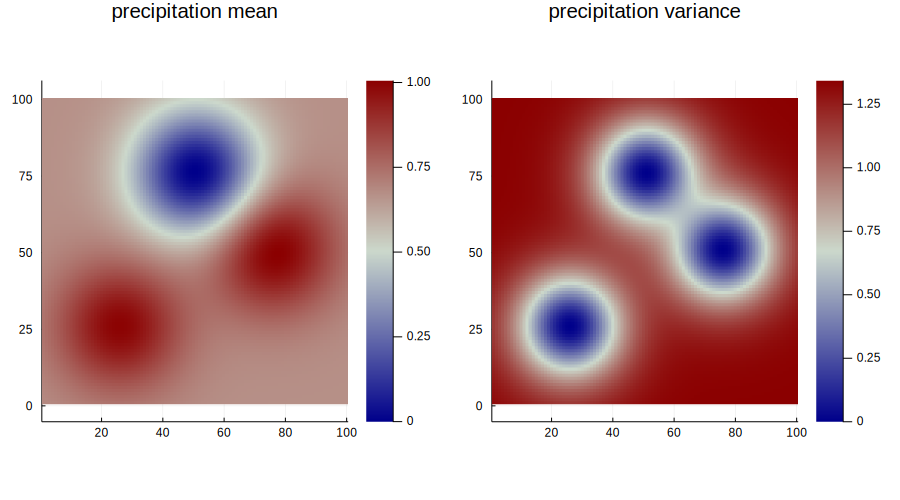

In [11]:
using Plots; gr(size=(900,500))

plot(solution)

Thanks to the integration with Plots.jl, many plot types are available:

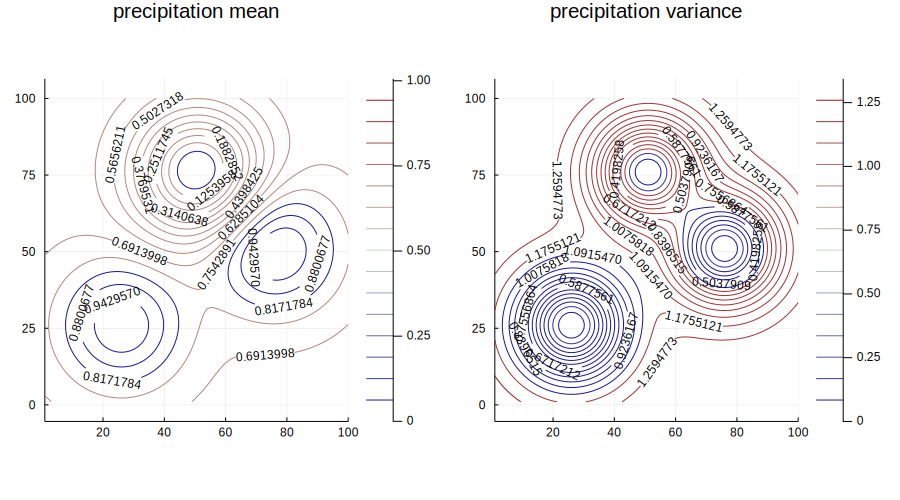

In [12]:
contour(solution, clabels=true)

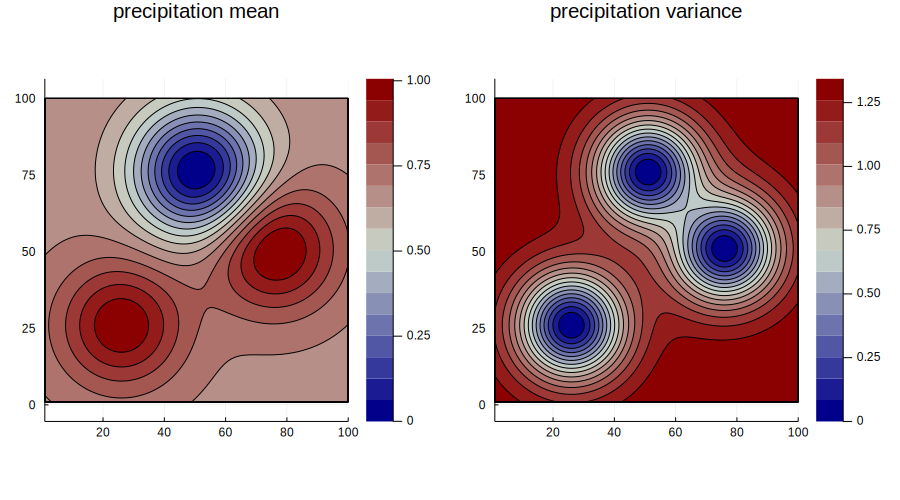

In [13]:
contourf(solution)

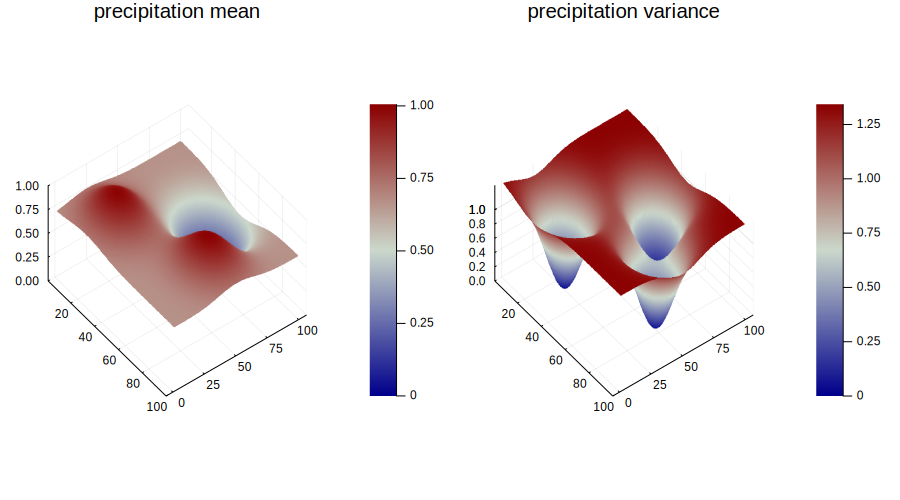

In [14]:
surface(solution, camera=(50,70))

## Conclusions

The ability to work at the level of the problem definition is quite desirable. Users can switch between different solvers without having to learn new syntax. This approach also guarantees that the problem being solved is the same and that the comparison is fair.

Documentation on how to write estimation solvers can be found in the [GeoStatsBase.jl](https://github.com/juliohm/GeoStatsBase.jl) package. Additional helper tools for developers can be found in [GeoStatsDevTools.jl](https://github.com/juliohm/GeoStatsDevTools.jl). Please open an issue if you have any questions about solver development.